# 注：数据特殊处理+采样

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
os.environ["export CUDA_VISIBLE_DEVICES"] = '0'

# 数据预处理

In [2]:
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
def process(df, cat_feats, dense_feats, is_normalize=True, inplace=False, dense_transformer=None, target="Group", le=None):
    """
    数据处理。
    1. 将类别变量展开为 one-hot;
    2. 数值特征的处理;
    """
    if not inplace:
        df = df.copy()
    
    for col in df.columns:
        if df[col].dtype == object and col != target:
            df[col][~df[col].apply(lambda x: type(x)).isin([float, int])] = np.nan
    
    # 处理类别特征 ont_hot embedding
    for cf in cat_feats:
        tmp = pd.get_dummies(df[cf])
        tmp.columns = [f"{cf}_{i}" for i in range(tmp.shape[1])]
        df = pd.concat([df, tmp], axis=1)
        
    df.drop(cat_feats, inplace=True, axis=1)
    
    if is_normalize:
        # 处理数值特征
        df = df.astype(dict(zip(dense_feats, [float]*len(dense_feats))))
        if not dense_transformer:
            scaler = preprocessing.StandardScaler().fit(df[dense_feats].values)
        else:
            scaler = dense_transformer
        df[dense_feats] = scaler.transform(df[dense_feats])
        transformer = scaler
    else:
        transformer = None
        
    # 对目标变量进行编码
    if le is None:
        le = preprocessing.LabelEncoder().fit(df[target])
    df[target] = le.transform(df[target])
    
    return df, transformer, le

In [3]:
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE,SMOTEN

#数据加载 + 缺失值补0
file_train = pd.read_excel("train1.xlsx").fillna(value=0)
file_test = pd.read_excel("test1.xlsx").fillna(value=0)

target = ['Group']
cat_feats = ['sex', 'ISS', 'ecog', 'bonelesion'] 
dense_feats = ['age', 'BUN', 'Totalprotein', 'Glucose', 'Hb', 'PLT', 'ALB', 'LDH', 'Cr', 'Ca', 'B2MG', 'ANC', 'WBC']

ptra, trans, le = process(file_train, cat_feats, dense_feats)
ptes, *_ = process(file_test, cat_feats, dense_feats, dense_transformer=trans, le=le)


y = ptra['Group'].values
ptra.drop(target, axis=1, inplace=True)
X = ptra.values
x_train, y_train = X, y

y_test = ptes[target].values
ptes.drop(target, axis=1, inplace=True)
x_test = ptes.values

# 类别不平衡处理 向下采样
sm = SMOTE()
X_resampled, y_resampled=sm.fit_resample(x_train, y_train)
# X_res_vis=pca.transform(X_resampled)
x_train, y_train = X_resampled, y_resampled
print(Counter(y_resampled))
print(Counter(y_train))

Counter({1: 240, 0: 240})
Counter({1: 240, 0: 240})


# XGBoost 参数寻优

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

xgb_pipeline = Pipeline(steps=[('classifier', XGBClassifier(eval_metric=['auc']))])
# 设置参数值域范围 [0.1, 0.2, 0.3, 0.5, 0.8, 1, 5, 10] [0.5, 1, 1.5, 2, 5]
params = {

    'classifier__min_child_weight': np.linspace(0.01,20,1000),
    'classifier__eta': np.linspace(0.01,20,1000),
    'classifier__base_score': np.linspace(0.01,1,200),
    #
    'classifier__gamma': np.linspace(0.01,30,1000),
    #
    'classifier__subsample': np.linspace(0.01,30,1000),
    #
    'classifier__colsample_bytree': np.linspace(0.01,1,100),
    #
    'classifier__max_depth': range(1,40)

}
# 所搜最优参数值
random_search = RandomizedSearchCV(xgb_pipeline, param_distributions=params, n_iter=200,
                                   verbose=3, random_state=1001)
random_search.fit(x_train, y_train)
# 打印最优参数
print(random_search.best_params_)
print(random_search.score(x_test, y_test))
print(random_search.score(x_train, y_train))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END classifier__base_score=0.3632160804020101, classifier__colsample_bytree=0.25, classifier__eta=19.37968968968969, classifier__gamma=29.81987987987988, classifier__max_depth=9, classifier__min_child_weight=4.092042042042041, classifier__subsample=19.162772772772772;, score=nan total time=   0.0s
[CV 2/5] END classifier__base_score=0.3632160804020101, classifier__colsample_bytree=0.25, classifier__eta=19.37968968968969, classifier__gamma=29.81987987987988, classifier__max_depth=9, classifier__min_child_weight=4.092042042042041, classifier__subsample=19.162772772772772;, score=nan total time=   0.0s
[CV 3/5] END classifier__base_score=0.3632160804020101, classifier__colsample_bytree=0.25, classifier__eta=19.37968968968969, classifier__gamma=29.81987987987988, classifier__max_depth=9, classifier__min_child_weight=4.092042042042041, classifier__subsample=19.162772772772772;, score=nan total time=   0.0s
[CV 4/5] END

# DecisionTreeClassifier 参数寻优

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# DecisionTreeClassifier().get_params().keys() #获取模型所有参数
dt = DecisionTreeClassifier()
# 设置参数值域范围
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best','random'],
    'min_samples_leaf': range(1,50),
    'max_depth': range(1,50)
}
random_search = RandomizedSearchCV(dt, param_distributions=params, n_iter=200,
                                   verbose=3, random_state=1001)
random_search.fit(x_train, y_train)
print(random_search.best_params_)
print(random_search.score(x_test, y_test))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END criterion=gini, max_depth=30, min_samples_leaf=46, splitter=best;, score=0.479 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, min_samples_leaf=46, splitter=best;, score=0.594 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, min_samples_leaf=46, splitter=best;, score=0.677 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, min_samples_leaf=46, splitter=best;, score=0.698 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, min_samples_leaf=46, splitter=best;, score=0.542 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=28, min_samples_leaf=22, splitter=best;, score=0.552 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=28, min_samples_leaf=22, splitter=best;, score=0.615 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=28, min_samples_leaf=22, splitter=best;, score=0.760 total time=   0.0s
[CV 4/5] END criterion=entropy, max_dep

# RandomForestClassifier 参数寻优

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# RandomForestClassifier().get_params().keys() #获取模型所有参数
dt = RandomForestClassifier(random_state=30)
# 设置参数值域范围
params = {
    'n_estimators': range(1,200,1),
    'min_samples_leaf':np.arange(1, 100, 1),
    'min_samples_split':np.arange(1, 100, 1),
    'criterion':['gini', 'entropy'],
    'max_features':np.arange(1,100,1),
    'max_depth':np.arange(1, 100, 1),
    'max_leaf_nodes':np.arange(1,100,1),
}
random_search = RandomizedSearchCV(dt, param_distributions=params, n_iter=200,
                                   verbose=3, random_state=1001)
random_search.fit(x_train, y_train)
# 打印最优参数
print(random_search.best_params_)
print(random_search.score(x_test, y_test))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END criterion=entropy, max_depth=99, max_features=13, max_leaf_nodes=90, min_samples_leaf=61, min_samples_split=13, n_estimators=116;, score=0.510 total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=99, max_features=13, max_leaf_nodes=90, min_samples_leaf=61, min_samples_split=13, n_estimators=116;, score=0.688 total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=99, max_features=13, max_leaf_nodes=90, min_samples_leaf=61, min_samples_split=13, n_estimators=116;, score=0.698 total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=99, max_features=13, max_leaf_nodes=90, min_samples_leaf=61, min_samples_split=13, n_estimators=116;, score=0.562 total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=99, max_features=13, max_leaf_nodes=90, min_samples_leaf=61, min_samples_split=13, n_estimators=116;, score=0.510 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=43, max_features=59, m

# 多模型比较

In [14]:
# 模型性能评估
from sklearn.metrics import confusion_matrix
# 混淆矩阵函数定义
def show_matrics(y_test, y_pred, labels=['0', '1']):
	conf_matrix = confusion_matrix(y_test, y_pred)
    # 根据混淆矩阵，获取对应的参数值
	TP = conf_matrix[1, 1]
	FN = conf_matrix[1, 0]
	FP = conf_matrix[0, 1]
	TN = conf_matrix[0, 0]
	show_metrics = [[FN, FP], [TN, TP]]
	fig, ax = plt.subplots(figsize=(8, 8))
	img = ax.imshow(show_metrics, cmap=plt.get_cmap("Blues"))
	n = len(labels)
	ax.set_title('Confusion Matrix')
	ax.set_xticks(range(n))
	ax.set_xticklabels(labels)
	ax.set_yticks(range(n))
	ax.set_yticklabels(labels)
	ax.set_xlabel('Predicted Label')
	ax.set_ylabel('True Label')
	for i in range(n):
		for j in range(n):
			text = f"{show_metrics[i][j]}"
			plt.text(j, i, text, horizontalalignment="center",
					 color="red")
	
	plt.colorbar(img)
	plt.show()

In [ ]:
'''
众数填充

模型XGBoost效果最好, 模型效果如下图所示
模型XGBoost: Acc值为0.80 	 AUC值为0.61
其他的模型："AdaBoost", "LogisticRegression","Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", "MLP"效果差一点
'''

[15:40:11] WARNING: ../src/learner.cc:576: 
Parameters: { "classifier__colsample_bytree", "classifier__gamma", "classifier__max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:40:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
模型XGBoost: train AUC值为0.50
模型DecisionTree: train AUC值为1.00
模型RandomForest: train AUC值为0.99
[15:40:11] WARNING: ../src/learner.cc:576: 
Parameters: { "classifier__colsample_bytree", "classifier__gamma", "classifier__max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by languag

<Figure size 432x288 with 0 Axes>

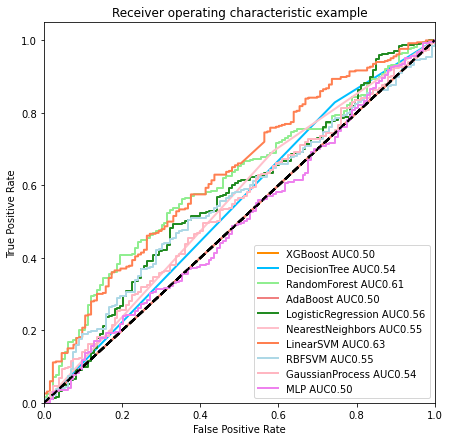

In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pylab import mpl
import seaborn as sns
plt.figure(facecolor='snow')
font_size = 12

from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = [ "XGBoost", "DecisionTree", "RandomForest", "AdaBoost", "LogisticRegression","NearestNeighbors", "LinearSVM", "RBFSVM", "GaussianProcess", "MLP",
         "NaiveBayes", "QuadraticDiscriminantAnalysis"]

# 模型列表 每一行代表一个模型，括号内是参数设置
classifiers = [
    XGBClassifier(subsample=0.13008008008008007, min_child_weight=10.995495495495494, classifier__max_depth=13, classifier__gamma=3.942622622622622,
                        classifier__colsample_bytree=0.55,eta=10.875435435435435,base_score=0.8557286432160804),
    DecisionTreeClassifier(splitter='random', min_samples_leaf=1, max_depth=32, criterion='entropy'),
    RandomForestClassifier(n_estimators= 178, min_samples_split= 17, min_samples_leaf= 10, max_leaf_nodes= 59, max_features=3, max_depth=27, criterion='gini'),
    AdaBoostClassifier(XGBClassifier(subsample=0.4, min_child_weight=10, classifier__max_depth=9, classifier__gamma=1.5,
                        classifier__colsample_bytree=0.6,eta=0.42894736842105263,base_score=0.0747917917917918)),
    LogisticRegression(random_state=1),
    KNeighborsClassifier(1),
    SVC(kernel="linear", C=0.025,probability=True),
    SVC(gamma=0.73, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    MLPClassifier(alpha=0.7, max_iter=1000)
            ]

# 画图展现
plt.figure(figsize=(7,7))
i = 0
colors = ['darkorange','deepskyblue','lightgreen','lightcoral','forestgreen','pink','coral','lightblue', 'lightpink', 'violet', 'teal', 'peru']

for name, clf in zip(names, classifiers):
    # 依次计算每一个模型的效果
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_pred_proba = clf.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
    
    print(f"模型%s: train AUC值为%.2f"%(name,roc_auc_score(y_train, clf.predict_proba(x_train)[:, 1])))

    lw = 2
    plt.plot(
        fpr,
        tpr,
        color=colors[i],
        lw=lw,
        label=name+" AUC%0.2f"%(roc_auc_score(y_test, y_pred_proba[:, 1]))
    )
    i += 1
    plt.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    # plt.savefig('auc_roc.pdf')
    # plt.show()


# 混淆矩阵

[15:40:39] WARNING: ../src/learner.cc:576: 
Parameters: { "classifier__colsample_bytree", "classifier__gamma", "classifier__max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:40:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
模型XGBoost: Acc值为0.74 	 AUC值为0.50


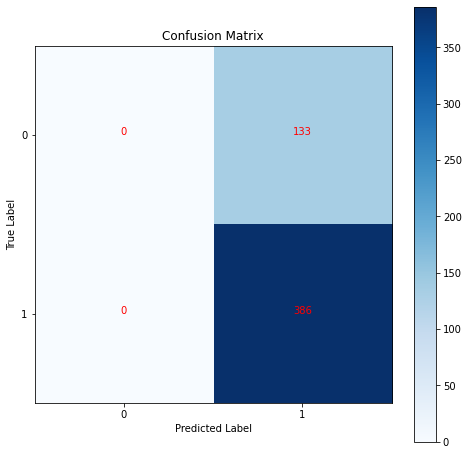

模型DecisionTree: Acc值为0.67 	 AUC值为0.54


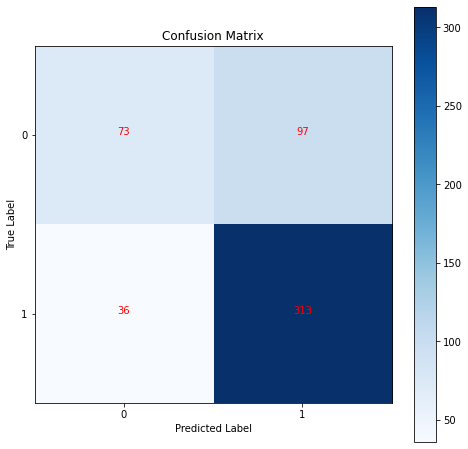

模型RandomForest: Acc值为0.71 	 AUC值为0.61


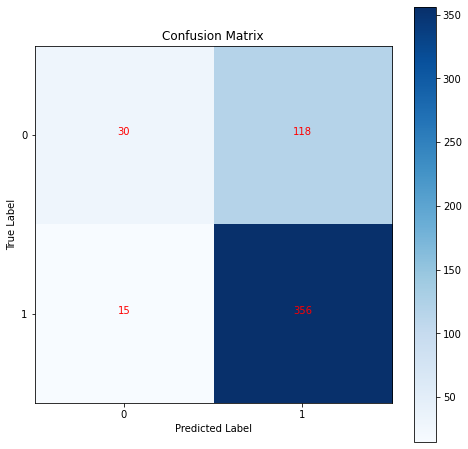

[15:40:40] WARNING: ../src/learner.cc:576: 
Parameters: { "classifier__colsample_bytree", "classifier__gamma", "classifier__max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:40:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:40] WARNING: ../src/learner.cc:576: 
Parameters: { "classifier__colsample_bytree", "classifier__gamma", "classifier__max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actua

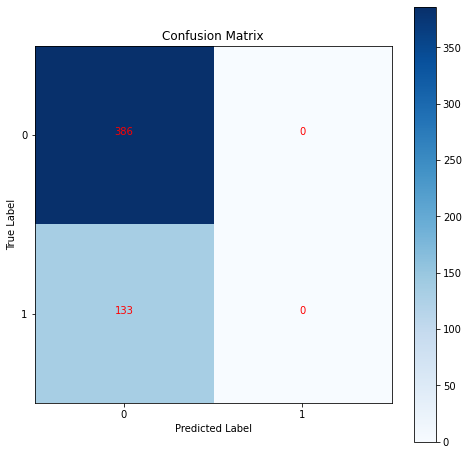

模型LogisticRegression: Acc值为0.62 	 AUC值为0.56


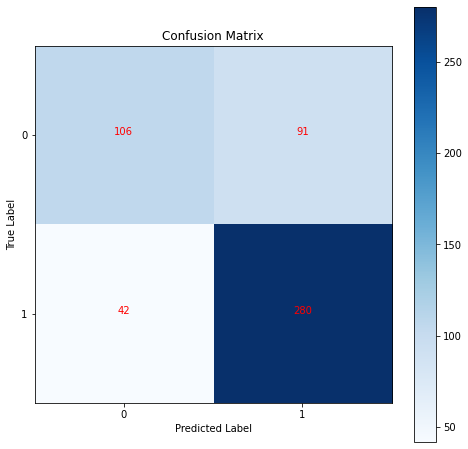

模型NearestNeighbors: Acc值为0.62 	 AUC值为0.55


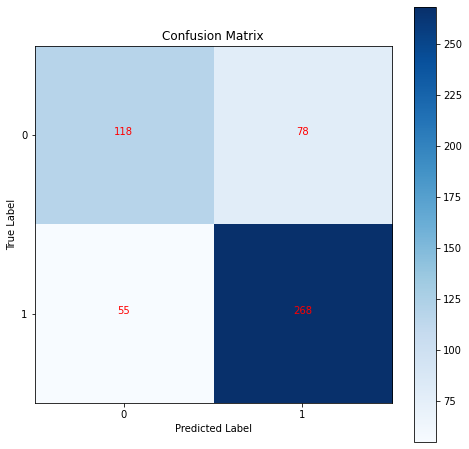

模型LinearSVM: Acc值为0.61 	 AUC值为0.63


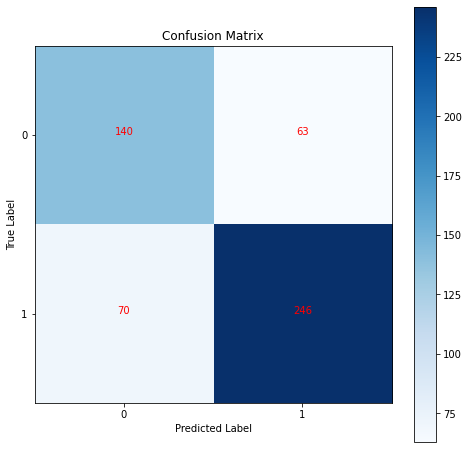

模型RBFSVM: Acc值为0.74 	 AUC值为0.55


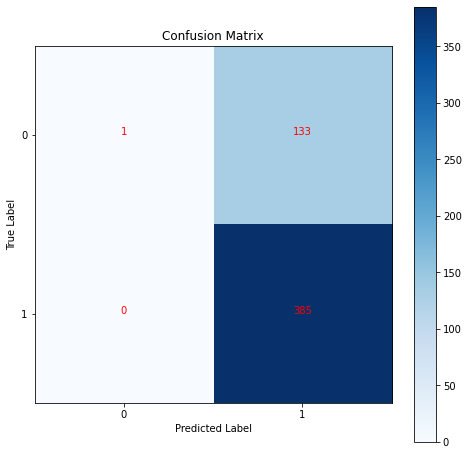

模型GaussianProcess: Acc值为0.67 	 AUC值为0.54


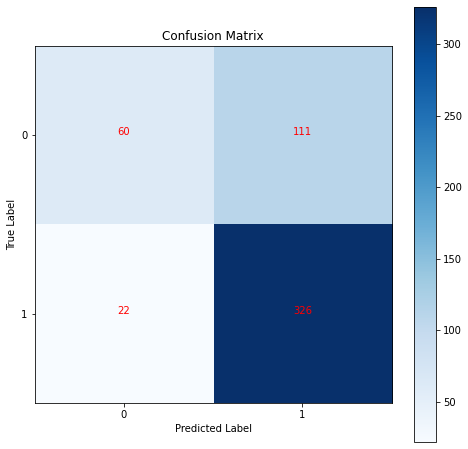

模型MLP: Acc值为0.67 	 AUC值为0.52


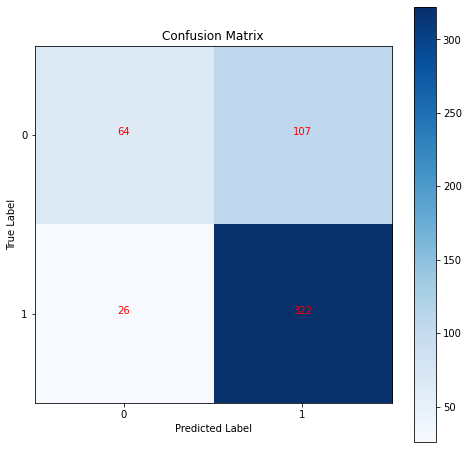

In [15]:
for name, clf in zip(names, classifiers):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    auc_score = roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])
    print(f"模型%s: Acc值为%.2f \t AUC值为%.2f"%(name,clf.score(x_test, y_test), auc_score))
    show_matrics(y_test.squeeze(), y_pred)